<a href="https://colab.research.google.com/github/Lasitha-Jayawardana/IDS/blob/main/K_Mean_UNSW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import math
from sklearn.cluster import KMeans
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,f1_score
from sklearn import preprocessing 

In [2]:
def loadData():
  global df_train
  global df_test
  
  df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project//UNSW_NB15_training-set.csv')
  df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project//UNSW_NB15_testing-set.csv')

  for col in ['proto','service','state']:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

  df_train=df_train.drop(columns='id')
  df_test=df_test.drop(columns='id')
  df_test.drop(df_test[df_test['state'] == 'ACC'].index, inplace = True)
  df_test.drop(df_test[df_test['state'] == 'CLO'].index, inplace = True)
  df_test.reset_index(drop=True,inplace=True) 
  df_train.reset_index(drop=True,inplace=True) 

In [3]:
#df_train.columns

In [4]:
#df_train.groupby('attack_cat')['attack_cat'].count()

In [5]:
#df_train[df_train['label'] == 0].groupby('attack_cat')['attack_cat'].count()

In [6]:
def balanceClass():
  global df_train
  global df_test
  # Class count
  count_class_0, count_class_1 = df_train['label'].value_counts()

  # Divide by class
  df_class_1= df_train[df_train['label'] == 0]
  df_class_0 = df_train[df_train['label'] == 1]
      
  df_class_0_under = df_class_0.sample(count_class_1)
  df_train = pd.concat([df_class_0_under, df_class_1], axis=0)
  df_train.reset_index(drop=True,inplace=True)
  df_train.groupby('label')['label'].count()

In [7]:
#balanceClass()

In [8]:
def addOtherLabel():
  global df_train
  global df_test
  label1 = 'other_proto'
  others2 = df_train['proto'].value_counts().index[7:]
  df_train['proto'] = df_train['proto'].cat.add_categories([label1])
  df_train['proto'] = df_train['proto'].replace(others2, label1)
  
  label2 = 'other_state'
  others3 = df_train['state'].value_counts().index[4:]
  df_train['state'] = df_train['state'].cat.add_categories([label2])
  df_train['state'] = df_train['state'].replace(others3, label2)
  
  df_test.drop(df_test[df_test['state'] == 'ACC'].index, inplace = True)
  df_test.drop(df_test[df_test['state'] == 'CLO'].index, inplace = True)
   
  others4 = df_test['proto'].value_counts().index[7:]
  df_test['proto'] = df_test['proto'].cat.add_categories([label1])
  df_test['proto'] = df_test['proto'].replace(others4, label1)
  
   
  others5 = df_test['state'].value_counts().index[4:]
  df_test['state'] = df_test['state'].cat.add_categories([label2])
  df_test['state'] = df_test['state'].replace(others5, label2)
  
  
  
#addOtherLabel()

In [9]:
def removeDuplicate():
  print('Duplicates train:',df_train.duplicated().sum())
  df_train.drop_duplicates(keep='first',inplace=True)
  print(df_train.duplicated().sum())

  print('Duplicates test:',df_test.duplicated().sum())
  df_test.drop_duplicates(keep='first',inplace=True)
  print(df_test.duplicated().sum())

  df_train.reset_index(drop=True,inplace=True)
  df_test.reset_index(drop=True,inplace=True)

In [10]:
def splitData():
  global X_train
  global Y_train
  global X_test
  global Y_test
  global df_train
  global df_test
  
  limit1 = df_train.shape[1]-1
      
  X_train = df_train.iloc[:,0:limit1-1] # train set features
  Y_train = df_train.iloc[:,limit1]
      
  limit2 = df_test.shape[1]-1
      
  X_test = df_test.iloc[:,0:limit2-1] # test set features
  Y_test = df_test.iloc[:,limit2]

In [11]:
def labelEncoding(X_train,X_test):
  label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
  X_train['proto']= label_encoder.fit_transform(X_train['proto' ]) 
  X_test['proto']= label_encoder.transform(X_test['proto' ]) 
  X_train['state']= label_encoder.fit_transform(X_train['state' ]) 
  X_test['state']= label_encoder.transform(X_test['state' ]) 
  X_train['service']= label_encoder.fit_transform(X_train['service' ]) 
  X_test['service']= label_encoder.transform(X_test['service' ]) 
  return X_train,X_test

#X_train,X_test = labelEncoding(X_train,X_test)


In [12]:
def one_hot_encode(X_train,X_test):
    
    categorical_cols = ['proto','service','state']
    # Training dataset one hot encoding
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    ohe.fit(X_train[categorical_cols])
    array_hot_encoded1 = ohe.transform(X_train[categorical_cols]).toarray()

    data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=X_train.index,columns=ohe.get_feature_names(categorical_cols))
    X_train = X_train.drop(columns=categorical_cols)
    X_train = pd.concat([data_hot_encoded1,X_train], axis=1)
    
    print('X_train shape :',X_train.shape)
    
    # Test dataset one hot encoding
    array_hot_encoded2 = ohe.transform(X_test[categorical_cols]).toarray()
    data_hot_encoded2 = pd.DataFrame(array_hot_encoded2, index=X_test.index,columns=ohe.get_feature_names(categorical_cols))
    X_test = X_test.drop(columns=categorical_cols)
    X_test = pd.concat([data_hot_encoded2,X_test], axis=1)
    
    print('X_test shape :',X_test.shape)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    Y_train.reset_index(drop=True,inplace=True)
    Y_test.reset_index(drop=True,inplace=True)
    return X_train, X_test

#X_train, X_test = one_hot_encode(X_train,X_test)

In [13]:
def scaling(X_train,X_test,scaler):
  
  X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
  return X_train,X_test

#X_train, X_test = scaling(X_train,X_test,StandardScaler())

In [29]:
def runPCA(X_train,X_test,kPCA):
  pca = PCA(n_components=kPCA, random_state = 453)
  X_rtrain = pca.fit(X_train).transform(X_train)
  X_rtest  = pca.transform(X_test)
  return X_rtrain,X_rtest

In [15]:
def searchKmeans():
 

  # Running K means with multible Ks
  best_seed = None
  

  X_value = X_train
  min_inertia = []
  #X_value = newdata.values
  seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
  for seed in seeds:
    inertia = []
    no_of_clusters = range(2,10)
    print('\n\n seed= {} \n'.format(seed))
    for f in no_of_clusters:
        kmeans = KMeans(n_clusters=f, init='k-means++',random_state=seed)
        kmeans = kmeans.fit(X_value)
        
        u = kmeans.inertia_
        inertia.append(u)
        print("The innertia for :", f, "Clusters is:", u) 
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
    if len(min_inertia) == 0 :
        min_inertia = inertia
        
    if min(inertia,default=0) < min(min_inertia,default=0):
        min_inertia = inertia
        best_seed = seed
    
    # Creating the scree plot for Intertia - elbow method
  fig, (ax1) = plt.subplots(1, figsize=(16,6))
  xx = np.arange(len(no_of_clusters))
  ax1.plot(xx, min_inertia,linewidth=4)
  ax1.set_xticks(xx)
  ax1.set_xticklabels(no_of_clusters, rotation='vertical')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia Score')
  plt.title('Inertia Plot per k for Best Seed {}'.format(best_seed))

  # between-a-point-and-a-line-in-2-d/
  def calc_distance(x1, y1, a, b, c):
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
    return d

  a = inertia[0] - inertia[-1]
  b = no_of_clusters[-1] - no_of_clusters[0]
  c1 = no_of_clusters[0] * inertia[-1]
  c2 = no_of_clusters[-1] * inertia[0]
  c = c1 - c2

  r = no_of_clusters[-1]-1
  r
  distance_of_points_from_line = []

  for k in range(int(r)):
    distance_of_points_from_line.append(
        calc_distance(no_of_clusters[k], inertia[k], a, b, c))
    
  plt.plot(no_of_clusters, distance_of_points_from_line)
  K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
  print("Best K value : {}".format(K))

  return  K,best_seed 

In [16]:
def XtoN():
  global X_trainN
  global X_testN
  global kmeans
  X_trainN = X_train
  X_testN = X_test
  

In [34]:
# Running K means with multible seeds
 
def searchSeed(X_train,no_of_clusters):
  global kmeans
  best_seed = None


  min_inertia=0.0
  
  seeds = [0,9500,10000,10500,11000,15000,18000 , 20000, 40000, 60000, 80000,90000, 120000]
  for seed in seeds:

    
    #print('\n seed= {} \n'.format(seed))
        
    kmeans = KMeans(n_clusters=no_of_clusters, init='k-means++',random_state=seed)
    kmeans = kmeans.fit(X_train)
    
    inertia = kmeans.inertia_
    #print("The innertia for : 2 Clusters is:", inertia) 
    # if current measurement of heterogeneity is lower than previously seen,
    # update the minimum record of heterogeneity.
    if min_inertia == 0 :
        min_inertia = inertia
        best_seed = seed
    if inertia < min_inertia:
        min_inertia = inertia
        best_seed = seed
        

  print("\nMin inertia : ", min_inertia)
  print("Best Seed : ",best_seed)
  return best_seed
 

In [18]:
#best_seed = searchSeed(X_trainN,5)


In [19]:
def runKmeans(k,best_seed):
  global kmeans
  # Running K means on K clusters
  kmeans = KMeans(n_clusters=k,init='k-means++', random_state=best_seed)
  kmeans = kmeans.fit(X_trainN)

In [20]:
def binaryaccuracyScore():
  label0 = 1- kmeans.labels_
  label1 = kmeans.labels_
  test_label1 = kmeans.predict(X_testN)
  test_label0 = 1 - test_label1

  a = accuracy_score(Y_train,label0)*100
  aa = accuracy_score(Y_train,label1)*100
  if (a>= aa):
    l = test_label0
    print("Accuracy Train: ",a)
  else:
    l = test_label1
    print("Accuracy Train: ",aa)

  print("Accuracy Test: ",accuracy_score(Y_test,l)*100)

  print("\nTest set precision : {:.4f}".format(precision_score(Y_test, l)))
  print("Test set recall    : {:.4f}".format(recall_score(Y_test, l)))
  print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, l)))
  
  cm = confusion_matrix(Y_test,l,normalize= 'true')
  print('True Positives  : {:.2f}'.format(cm[1][1]))
  print('True Negatives  : {:.2f}'.format(cm[0][0]))
  print('False Positives : {:.2f}'.format(cm[0][1]))
  print('False Negatives : {:.2f}'.format(cm[1][0]))

In [21]:

#binaryaccuracyScore()


In [22]:
def oneVsAllScore(n,Trainlabel,Testlabel): 

  def oneVsAll(number):
    if (number ==nn):
      return 0
    else:
      return 1
  m=[]
  
  for i in range(0, n):
    nn=i
    m.append(accuracy_score(Y_train,np.array(list(map(oneVsAll, Trainlabel)))))
    print(i,"  ",accuracy_score(Y_train,np.array(list(map(oneVsAll, Trainlabel)))))

  print("Accuracy Train: ",max(m)*100)
  index =m.index(max(m))
  nn=index
  #print(nn)
  a=np.array(list(map(oneVsAll, Testlabel)))
  print("Accuracy Test: ",accuracy_score(Y_test,a)*100)
  print("Test set precision : {:.4f}".format(precision_score(Y_test, a)))
  print("Test set recall    : {:.4f}".format(recall_score(Y_test, a)))
  print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, a)))
  cm = confusion_matrix(Y_test,a,normalize= 'true')
  print('True Positives  : {:.2f}'.format(cm[1][1]))
  print('True Negatives  : {:.2f}'.format(cm[0][0]))
  print('False Positives : {:.2f}'.format(cm[0][1]))
  print('False Negatives : {:.2f}'.format(cm[1][0]))
 

In [23]:
#onevsallscore(5,kmeans.labels_,kmeans.predict(X_testN))


In [33]:
def mapMethodScore(n):
  
  l0=[]
  Trainlabel = kmeans.labels_
  Testlabel = kmeans.predict(X_testN)
  def lmap(num):
    if (num in l0):
      return 0
    else:
      return 1
  
  for i in range(0, n):

    #print("Cluster ", i)
    c = Y_train[Trainlabel==i]
    if (len(c[c == 1])<len(c[c == 0])):
      l0.append(i)
      #print("add to normal ",i)
    #print("intrusion : ",len(c[c == 1]))
    #print("normal : ",len(c[c == 0]))

  ltrain = np.array(list(map(lmap , Trainlabel)))
  print("Accuracy Train: ",accuracy_score(Y_train,ltrain)*100)

  ltest = np.array(list(map(lmap , Testlabel)))

  print("Accuracy Test: ",accuracy_score(Y_test,ltest)*100)
  print("Test set precision : {:.4f}".format(precision_score(Y_test,ltest)))
  print("Test set recall    : {:.4f}".format(recall_score(Y_test,ltest)))
  print("Test set F1-score  : {:.4f}".format(f1_score(Y_test,ltest)))
  cm = confusion_matrix(Y_test,ltest,normalize= 'true')
  print('True Positives  : {:.2f}'.format(cm[1][1]))
  print('True Negatives  : {:.2f}'.format(cm[0][0]))
  print('False Positives : {:.2f}'.format(cm[0][1]))
  print('False Negatives : {:.2f}'.format(cm[1][0]))



method 1


Duplicates train: 67601
0
Duplicates test: 26387
0
X_train shape : (107740, 194)
X_test shape : (55940, 194)


 seed= 0 

The innertia for : 2 Clusters is: 3838986.462092474
The innertia for : 3 Clusters is: 3479871.6735677547
The innertia for : 4 Clusters is: 3153086.2738095056
The innertia for : 5 Clusters is: 2894456.193600197
The innertia for : 6 Clusters is: 2571276.114316198
The innertia for : 7 Clusters is: 2283670.037184958
The innertia for : 8 Clusters is: 2075700.7617702943
The innertia for : 9 Clusters is: 1797928.9081359669


 seed= 20000 

The innertia for : 2 Clusters is: 3838986.462092474
The innertia for : 3 Clusters is: 3479871.6735677547
The innertia for : 4 Clusters is: 3153027.2434876673
The innertia for : 5 Clusters is: 2845235.6980719883
The innertia for : 6 Clusters is: 2567505.1045764107
The innertia for : 7 Clusters is: 2297503.5399475917
The innertia for : 8 Clusters is: 2076834.1526807554
The innertia for : 9 Clusters is: 1915564.4711465053


 seed

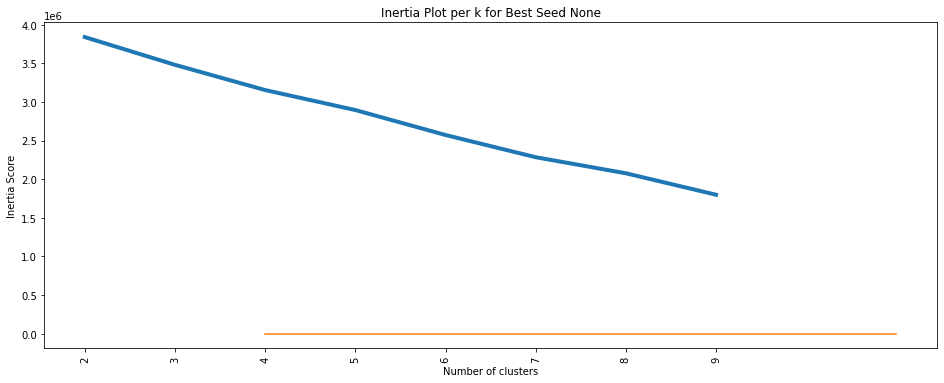

In [45]:
print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()


X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
X_train,X_test = runPCA(X_train,X_test,15)

K,best_seed = searchKmeans()
XtoN()

#best_seed = 10000
#K = 2
#best_seed = searchSeed(X_trainN,K)

runKmeans(K,best_seed) 

#binaryaccuracyScore()
print("One Vs All.........")
print(X_testN.shape)
print(Y_test.shape)
oneVsAllScore(K,kmeans.labels_,kmeans.predict(X_testN))
print("Map method.........")
mapMethodScore(K)




In [36]:

print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
#balanceClass()
#print(df_train.groupby('label')['label'].count())
#addOtherLabel()
removeDuplicate()
splitData()
X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
X_train,X_test = runPCA(X_train,X_test,20)
#K,best_seed = searchKmeans()
XtoN()

#best_seed = 20000
K = 10
best_seed = searchSeed(X_trainN,K)

runKmeans(K,best_seed) 

#binaryaccuracyScore()
print("One Vs All.........")
oneVsAllScore(K,kmeans.labels_,kmeans.predict(X_testN))
print("Map method.........")
mapMethodScore(K)



method 1


Duplicates train: 67601
0
Duplicates test: 26387
0
X_train shape : (107740, 194)
X_test shape : (55940, 194)

Min inertia :  2157544.310748027
Best Seed :  0
One Vs All.........
0    0.41127714869129384
1    0.2664934100612586
2    0.5241600148505662
3    0.6140709114534991
4    0.5175515129014294
5    0.7602283274549843
6    0.5236866530536477
7    0.4922127343604975
8    0.5188416558381288
9    0.5184982364952664
Accuracy Train:  76.02283274549842
Accuracy Test:  58.84697890597068
Test set precision : 0.4854
Test set recall    : 0.9815
Test set F1-score  : 0.6495
True Positives  : 0.98
True Negatives  : 0.34
False Positives : 0.66
False Negatives : 0.02
Map method.........
Accuracy Train:  86.75979209207351
Accuracy Test:  67.85663210582767
Test set precision : 0.5493
Test set recall    : 0.9623
Test set F1-score  : 0.6994
True Positives  : 0.96
True Negatives  : 0.50
False Positives : 0.50
False Negatives : 0.04


In [37]:
print("method 1\n\n")
loadData()
#df_train.columns
#print(df_train.groupby('attack_cat')['attack_cat'].count())
balanceClass()
#print(df_train.groupby('label')['label'].count())
addOtherLabel()
removeDuplicate()
splitData()


X_train, X_test = one_hot_encode(X_train,X_test)
#X_train,X_test = labelEncoding(X_train,X_test)
X_train, X_test = scaling(X_train,X_test,StandardScaler())
X_train,X_test = runPCA(X_train,X_test,30)
#K,best_seed = searchKmeans()
XtoN()

#best_seed = 10000
K = 10
best_seed = searchSeed(X_trainN,K)

runKmeans(K,best_seed) 

#binaryaccuracyScore()
print("One Vs All.........")
print(X_testN.shape)
print(Y_test.shape)
oneVsAllScore(K,kmeans.labels_,kmeans.predict(X_testN))
print("Map method.........")
mapMethodScore(K)


method 1


Duplicates train: 30471
0
Duplicates test: 26611
0
X_train shape : (81529, 65)
X_test shape : (55716, 65)

Min inertia :  2307276.229375544
Best Seed :  0
One Vs All.........
(55716, 30)
(55716,)
0    0.2958456500141054
1    0.31850016558525185
2    0.49299022433735235
3    0.37118080682947174
4    0.3488819929104981
5    0.37217431834071313
6    0.6440530363428963
7    0.36788136736621324
8    0.33377080548025856
9    0.3630364655521348
Accuracy Train:  64.40530363428964
Accuracy Test:  56.213654964462634
Test set precision : 0.4682
Test set recall    : 0.9860
Test set F1-score  : 0.6349
True Positives  : 0.99
True Negatives  : 0.30
False Positives : 0.70
False Negatives : 0.01
Map method.........
Accuracy Train:  79.4122336837199
Accuracy Test:  65.25414602627612
Test set precision : 0.5273
Test set recall    : 0.9666
Test set F1-score  : 0.6824
True Positives  : 0.97
True Negatives  : 0.46
False Positives : 0.54
False Negatives : 0.03
